# Signal modelling and source separation - GSMM models

This notebook trains signal models and performs source separation for multiple signals.

The signal model is given as
$$ To appear soon (hopefully) $$

The observation model is given as
$$ p(y_k \mid x^{1:N}_k) = \mathcal{N}\left(y_k \mid \sum_{n=1}^N x^n_k, \ \gamma_y^{-1}\right)$$



## Load packages

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using FFTW
using Compat
using WAV
using DSP
using Base64
using Statistics
using ForneyLab
using LinearAlgebra
using ProgressMeter
using PyPlot
using GaussianMixtures
using Random
using Printf
using BenchmarkTools
using HDF5
import Distributions: MvNormal, logpdf
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
include("../extensions/ComplexNormal.jl")
include("../extensions/GSMM.jl")
include("../extensions/ComplexHGF.jl")
include("../extensions/ComplexToReal.jl")
include("../extensions/GSMM_paper.jl")

include("../functions/auxiliary/workflow.jl") 
include("../functions/auxiliary/fourier.jl") 
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/preprocessing.jl") 
;

## Parameters

In [3]:
# signal definition
sound_files = ["../data/woman.wav",            # specify sound sources to model and separate (can be more than 2)
               "../data/cocktail_party.wav"]
fs_desired = 8000                              # specify desired sampling frequency of signals
duration_train = 3                             # specify duration of training signals
duration_sep = 10                              # specify duration of mixture signal
normalization_method = "std"                   # specify method to use for normalizing the signals

# save folders
folder_params = "inferred/GSMM_model"          # specify folder to save inferred values in (to save time when recomputing)
folder_figures = "figures/GSMM_model"          # specify folder to save figures in
folder_audio = "audio/GSMM_model"              # specify folder to save audio in

# inference and modelling
nr_clusters = [15,15] # was 11 3                 # number of clusters in GSMM (if you want to use 2 orders: see footnote below notebook)
nr_freqs = 39#was 24                           # number of frequencies in log-power domain (excluding DC and fs/2)
overlap_train = 0.9  #was 0.5                  # portion of overlap during training
overlap_sep = 0.5                              # portion of overlap during source separation
iterations_train = 200
iterations = 2                                 # number of iterations for variational message passing
Σ_meas_train = 1e-4  # was 1e-4               # assumed precision of measurement noise during training
Σ_meas_sep = 2e-4                              # assumed precision of measurement noise during source separation
window=hanningwindow                       # specify windowing function
dBnoise = -15
;

In [4]:
# auxiliary variables
bufsize = 2*(nr_freqs+1)                                                             # size of time-domain buffer
stepsize_train = Int(round(bufsize*(1-overlap_train)))                               # stepsize during training
stepsize_sep = Int(round(bufsize*(1-overlap_sep)))                                   # stepsize during source separation
nr_samples_train = Int((fs_desired*duration_train-bufsize)/stepsize_train) + 1       # number of samples during training
nr_samples_sep = Int((fs_desired*duration_sep-bufsize)/stepsize_sep) + 1             # number of samples during source separation
freqs = abs.(FFTW.fftfreq(bufsize)[1:nr_freqs+2]*fs_desired)[2:end-1]                # frequencies of probabilistic Fourier transform
;

## Load and preprocess data

In [5]:
# create array for time signals and log-power signals
signal = Array{Array{Float64,1},1}(undef, length(sound_files))
signal_sep = Array{Array{Float64,1},1}(undef, length(sound_files))
signal_z = Array{Array{Float64,2},1}(undef, length(sound_files))
signal_fr = Array{Array{Complex{Float64},2},1}(undef, length(sound_files))
signal_sep_z = Array{Array{Float64,2},1}(undef, length(sound_files))

# load signals, preprocess, crop and save
for k = 1:length(sound_files)
    
    # load signal
    signal_tmp, fs_tmp = wavread(sound_files[k], format="native")
    fs_tmp = Int(fs_tmp)
    signal_tmp = Float64.(signal_tmp)
    
    # crop signal
    signal_tmp = signal_tmp[1*fs_tmp+1:(1+duration_train)*fs_tmp]
    
    # preprocess signal and save
    signal[k] = preprocess(signal_tmp, fs_tmp, fs_desired=fs_desired, normalization_method=normalization_method)
    
    if k == 2
        signal[k] = signal[k]*10^(dBnoise/20)
    end
    
    # take windowed fft of signal
    signal_tmp = FFTovertime(signal[k], bufsize, bufsize-stepsize_train, window)

    # reduce fft
    signal_fr[k] = fft_reduce(signal_tmp)
    
    # get the log abs values
    signal_z[k] = log.(abs2.(signal_fr[k]))
        
end

# create mixture signal 
ymix = zeros(duration_sep*fs_desired)
for k = 1:length(sound_files)
    
    # load signal
    signal_tmp, fs_tmp = wavread(sound_files[k], format="native")
    fs_tmp = Int(fs_tmp)
    signal_tmp = Float64.(signal_tmp)
    
    # crop signal
    signal_tmp = signal_tmp[1*fs_tmp+1:(1+duration_sep)*fs_tmp]
    
    # preprocess signal and save
    signal_sep[k] = preprocess(signal_tmp, fs_tmp, fs_desired=fs_desired, normalization_method=normalization_method)
    
    if k == 2
        signal_sep[k] = signal_sep[k]*10^(dBnoise/20)
    end
    
    # take windowed fft of signal
    signal_tmp = FFTovertime(signal_sep[k], bufsize, bufsize-stepsize_sep, window)

    # reduce fft
    signal_tmp =  hcat(real.(signal_tmp[:,1]), 2*real.(signal_tmp[:,2:nr_freqs+1]), real.(signal_tmp[:,nr_freqs+2]), -real.(signal_tmp[:,1]), -2*imag.(signal_tmp[:,2:nr_freqs+1]), imag.(signal_tmp[:,nr_freqs+2]))

    # get the log abs values
    signal_sep_z[k] = log.(abs2.(signal_tmp[:,2:nr_freqs+1]) + abs2.(signal_tmp[:,nr_freqs+4:end-1]))
    
    # preprocess signal and sav
    ymix = ymix + signal_sep[k]
        
end

# calculate low-power spectrum of mixture signal
zmix = FFTovertime(ymix, bufsize, bufsize-stepsize_sep, window)
zmix =  hcat(real.(zmix[:,1]), 2*real.(zmix[:,2:nr_freqs+1]), real.(zmix[:,nr_freqs+2]), -real.(zmix[:,1]), -2*imag.(zmix[:,2:nr_freqs+1]), imag.(zmix[:,nr_freqs+2]))
zmix = log.(abs2.(zmix[:,2:nr_freqs+1]) + abs2.(zmix[:,nr_freqs+4:end-1]))

# create time axis
t_train = collect(1:length(signal[1]))/fs_desired
t_sep = collect(1:length(ymix))/fs_desired
;

## Visualise signals

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCDeYK/PIuyv4mLer9R0lO/5fYSv3DFjr2YMB4/ydGPP5kM2z+gQg9AlUweQN0fFUDRDRBAbiC0P+uORj4LMpi+rkZ8vg5Ohb+uCfO/alvKv7jpNb/LD+q+uOfMvgXtT7vXe+o+9L/kPvmpKz75qCW+21z/vnFrHb8/x06/mVmRv+LXr7+wzo+/P9dIv2PhHb+sLtO+nqSVPjJokD+2R9Q/8kT/P5qXGUAzgh5Arx4YQJS1yz+EH8U+XXuEvs5ygr5Gt3q/eqT5vzL66r+RrWu/NkPzvlSVEb89jnW+JinIPs++FT8rFLU+OfD1PV9vJ74GHe6+uq86v8KSdr+8+aa/z5yiv/dnfb9cbzy/f1PTvlXXwz7oSqg/iqbsP3MOC0DH6iRA3GUtQORvBUAc5Tc/+EqoPbu0sDqCNzq/RxYAwJqxCcBCS6O/XuZOv297dL+wnCy/qqaAPjjHVT/xLxo/24BGPjSuBT7Mp4E+4ugnvgwcZ78bEqK/3xOOv2lTfr/jBX+/CX5Nvye2Nr185WM/GB3HP4nk6z9sBA5APPMnQLBeGUALraA/cVYKPpxCKj2FSka+Emq2v9Z7FcDnnt+/yuKFv/y4iL8psoa/WEqwvs2lpT4rsAI/Ahm3PtxaCT4KDyU9CocXPqOiKL5lNl+/h/SAvxoi+r4sC4W+l+yPvltC8j5/WNg/JQoPQI/5DkD3vBBAjD7BP7CHKj/X5e4+mWSmvSNQw78gpgLAIYW0v/Ztmr+8RMO/R5ySv79wD771lO8+kUEjP+MuTj9MPCM/8BLUPl0a5D7wNzQ+86FGv8OArb+CZ36/9/Vgv2rusL+PeKK/pLSrvu/qnz73v90+QORXP5vntj+UVNk/IdC8P02mmj/NX3M/uWQiP3HOVT7VQIa+vSXIvr4d1r5ZtUq/NeGOv5A/Tr80dAy/dk8tvx1HIr+8JOq97bXOPWgIH75jsqa+8/B3vqiQGr7VOhy+qN/EvVv/+D082SE/bd2ePzK71T8kkPY/lfQTQFkGAkAy0h4/nnrGvUNuaj6jx8u+xZsBwOSnBsB5RG+/AIhXv2i/vr/iFl2/aSfsPvA9aD9eySw/XeJZP2BJmj+YCpY/P8A/P+KzDT7+pra+8QIbv25DL781PYi/bZ2ov32agr+4sPS+WoTMvjpctr7w3846Ts3XPnauzz7WmXk+E214PmZwgD4bYWw9YJ+Kvue0rL6X62u+98pAvlirhb5f6Hq+VgI0vkkFZLxvfHc9uxbAPBXXK71KcE09B2SoPYoIbr15wGS+CeAyvl1WZb1f1Aa+RcqWvT/M9j1X8W8+jyBiPnKDnD6NsMM+OCXcPjEMsz5gdHE+5zEkPhLqAD6nr5w86WpjvhvHob6/Jpu+eP2+vv6qAr8Bkt6+s6msvmmUrL5X1qa+jp5KvnHqBL4yV/S9hJksvYaNTj1IAM09I9NLPgrRwz4jm9s+sDPkPkGOGD8KKTA/FwoXP27L6T4VU6M+ca5dPiY7qryaepC+BlESv93fP7/0qUq/waRKv6GcZb9jf1q/q+AYv1Ci377UUrS+jfBBvhuZhDtsefc9dOR4PvwIoz64gcs+h70gP4P9ZT8/rYY/EqmaP9genz/Q8H8/D6IYP0O84T5Nnda8myM2v0XUhL8LTIG/6s6cvxYKxL/3hqW/Zypcv4PJOr+AaCm/24CHvt2P5T37nGA+DSOgPiGXBT9D7zM/fR5DPw+aaD/FYJc/HMi3P459xj/GSY8/n12vPlTgUz5UhbI+hHu1viB1pL9UpXq/smrpvkttfr97dqi/g1kMv1l+GT3FXoC+U6b3vfZNCT+ihjI/kGO9PjJZwD6BlgU/iGxaPp4GVr5V6nW+h/aBvjqbBr+K5ia/YiwTvyYtBb/GH+++BnWzvkx0RL5l9qG98qXAvXuXl73Y1+g7+57hPfPB0DxgmYq9cAfyPGCUdj2rkIu9Fyl/vYNCTj1MKB+99Xj/vX6Uvr31xnm9X4d8vafsAr0ODt88aO8zPffzcT39QYw95cy3PToeaT4P+3w+nD0aPnqF6z3jWFU+t3I+PgGE0j3j/BM+hZkhPgFRVj1b5nu7E/iqOmiaPL1eGmq9+ch3vcQSXL05pmG9q9FhvT0gjLv634W8mPtyPAd6TT3J1RA9XqKvPbw/Gz7cT6M9C+fCPTwDRz5cowc+aaEQPRht2D0RJkE+SS3fPXj4Xz2WlUI9zkl2u5/SfT2lx+M9r8Frvapojr1+d7A97K+OPSm3W71d7Is8OaoaPf/a4DtBAIE9F7MvPUL2lDvA3kA96HndPeoZbj2f61g8jPy9PSehUD0EPgs+gD6YPTsppju7dE8+KQ3WPe76eD3vvy4+BezKPO2EvztSIiA+4xmdPWMf7b0RnSO95F+MOsmHx72gjXi88U8ZPFUOlr2XsIg9ch0mvfTAQr7QLdw9gVZPPoBe7b3yeoO+MhCuPZ8Gbz6fkEa+zzUevllXfz4K1ge+fsJUvknlhT4pi4S8rObEvvfRuzxUngY+WzxwvlQAiL6axQO9n7SSvaYAKb4UD0i9b542vi53wr3zqxI+0gDnvbAqob4KLeE9snGTPdXLcb4tIqa9uYwqPZuekr21ix6+sOr5vHMbmTwZRi6+uUcRvlK2Kr1ImDi9594ovgXIG77yWEu90Pu3vRGLkb1SD0O9hiZivHKVNrwZ5q683fq0vPZfzTtHjNA8YXUkvb9G5byEDa27SN7Juycps7wTa3W9x8oGvemBFb27fgC6hNIiPG6zkztvjSo7ghQtPcSCjTtexQe93P5pvN5FKb1yqYi9HvGLvd04Yb0DWom9Z7rVvfRFl70Xhzm9TSIdvLVazLzg5qU7E6aLPUySgT1lLOo8wQoqPeltYT2Ls8Q8RNCbPFIloDzhj905T1PpO5G7BLryd9i7k/UUvADWJ7yuJ3Y8zHxKO2VhEr0vtxm9RJNHvZgIXb2SKmC9y2FHvRo4QLxCobo7JtQSPf6uTTxOcdM7PnJJPcyzZj3Um5Y8Bol1u6wYGj0STSM9638wvIHZxbrndSQ9KxEgPRqqfzvz07Q7BkUlPfeEKT0r/2A935eAPTnkpD3LlIU9riqZPS2Wez2BHUo9HFBvPY0dET0fE4E8iswoPcy9JT2Lt5M9NZSAPXL3NT3/k1Y909JRPZDEND2JER89qkRrPU/jnT1gXC89PtQGPQXQcz2yxkc9t3eFPTCh0j2lC689QhBxPeR0hj17MIU9esyUPNgYLD2IVt47pPkEvf/UN71O4Cq9ozjNvByKGL3Q5fc60d3tPOV1QDy0NNM70Z2UPNUROjwTf8G8UR0tveosab3Vuom93UCIvUFYwr3F6ea9lFbevYIWyb1Rgv29t37GvcOErL2LAdS9m+jYvYyW173Qcdu96FUIvrMr/L3VEw6+0EcOvsbGCb4PLwC+iQQMvjbEA77OB5S9y9PTvRnszL2rvay9vXWhvarBor3Defq9iP3+vfZJBr4OCd69Z8HNvaJW0r1P2c29f2y/ve160b1Z/eq9He3jva/im73UT669o3HLvUZfmr17lmW9CG+Ivd7iKr3p+/u8B9KIvVHIdL1s+ge9uKTQvArPzrx46QO9K5EhvQTdhriyVCu8TaAWu/u0JTz3i+07RWHJPGcwZDwOogY888LtPAfcNbzuHui8OPEhPFYPmDsTeWs83XMHPAi7Lz011xI9sDfkPG8taz2iA4g9noJtPQ2pzD1OpZg9uKWTPZpkhj137nI9oBSXPWRaUD1NM6Q9+I15PYAKQD0uF1A9WmGoPSgLnT14EHo9Kcu6Pc9juj2kkWI9IXCQPZwptz0a8dE90CjYPaQ/zD2IW7w9IPnWPaxz/T3OILw9tJyTPZijvT1uT

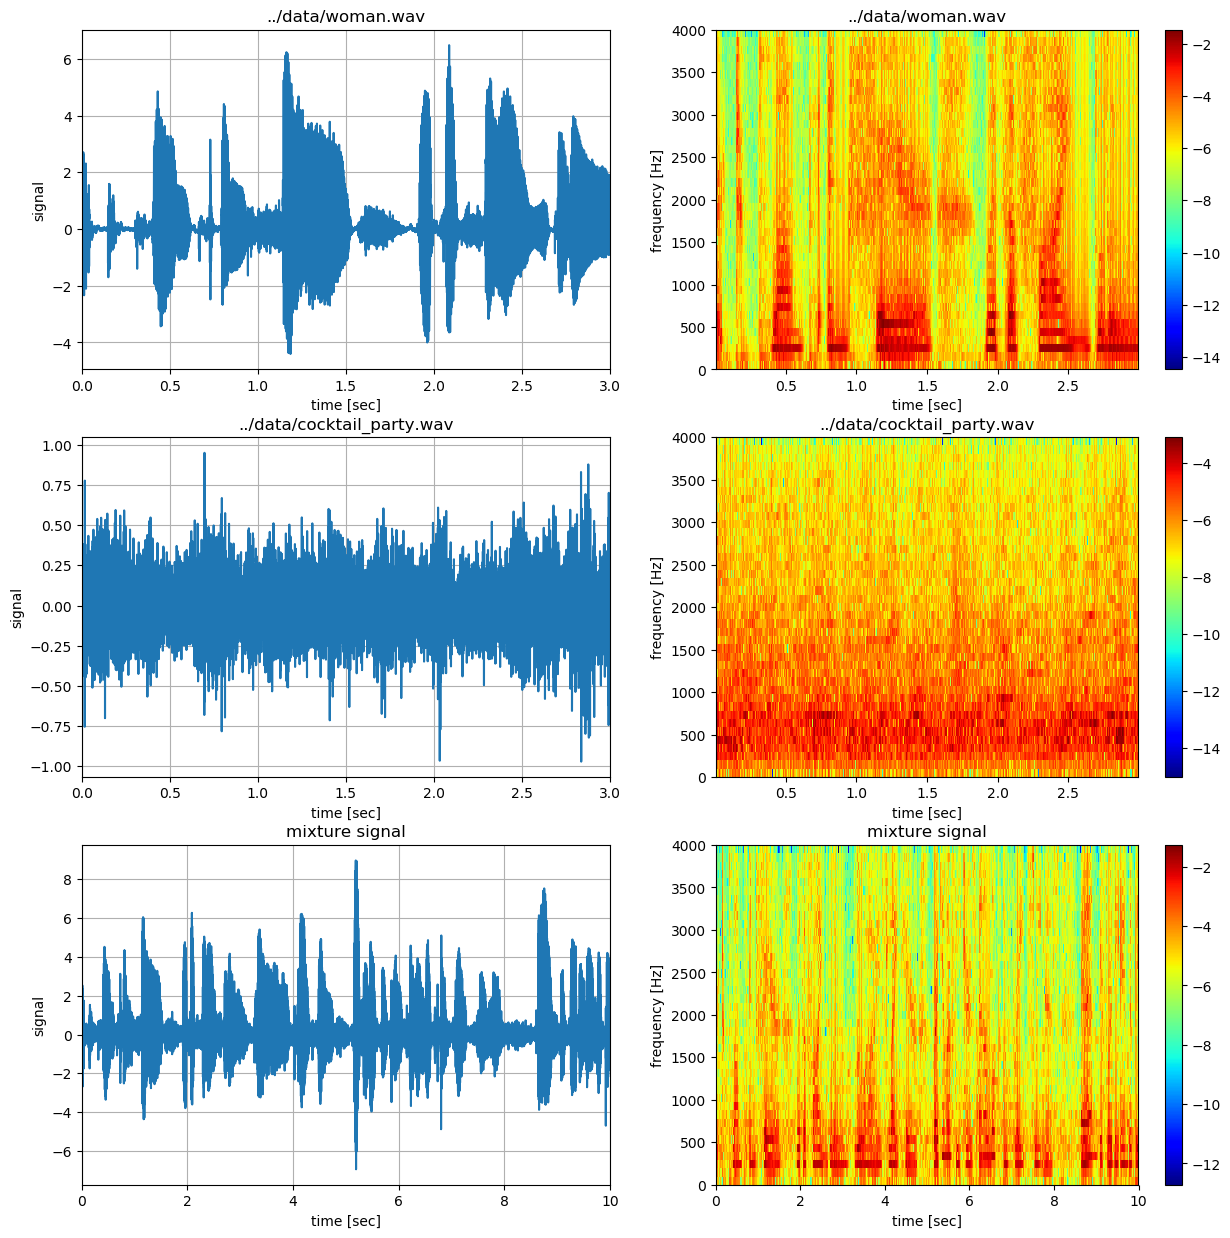

In [6]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files)+1, figsize=(15, 5*(length(sound_files)+1)))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k,1].plot(t_train, signal[k]), ax[k,1].set_xlim([0, duration_train]), ax[k,1].set_xlabel("time [sec]"), ax[k,1].set_ylabel("signal"), ax[k,1].grid(), ax[k,1].set_title(sound_files[k])
    
    # plot spectrogram of signal
    plot_spectrogram(spectrogram(signal[k], bufsize, bufsize-stepsize_train, fs=fs_desired), fs_desired, ax=ax[k,2], colorbar=true), ax[k,2].set_title(sound_files[k])

end

# finally add mixture signals
ax[end,1].plot(t_sep, ymix), ax[end,1].set_xlim([0, duration_sep]), ax[end,1].set_xlabel("time [sec]"), ax[end,1].set_ylabel("signal"), ax[end,1].grid(), ax[end,1].set_title("mixture signal")
plot_spectrogram(spectrogram(ymix, bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=ax[end,2], colorbar=true), ax[end,2].set_title("mixture signal")

# create audioplayers
audioplayers(signal..., ymix, fs=fs_desired)
;

## Define signal model

In [7]:
# create expression that can draw an entire graph in a factor graph statement
function signal_model(k, nr_clusters, nr_freqs, bufsize)
    
    # wrap code into an expression to execute later on in a factor graph type to allow for modularity
    model = quote
        
        # create dictionary for variables
        if !@isdefined vars
            vars = Dict()
        end
        
        # create mixture components
        for ki = 1:($nr_clusters)

            # specify distribution over mean
            @RV vars[pad(pad(:ξ,ki),$k)] ~ GaussianMeanPrecision(placeholder(pad(pad(:μ_ξ,ki),$k), dims=($nr_freqs,)), placeholder(pad(pad(:Λ_ξ,ki),$k), dims=($nr_freqs,$nr_freqs)))

        end

        # specify distribution over categorical distribution
        @RV vars[pad(:π,$k)] ~ Dirichlet(placeholder(pad(:α_π,$k), dims=($nr_clusters,)))

        # specify distribution over selection variable
        @RV vars[pad(:z,$k)] ~ Categorical(vars[pad(:π,$k)])

        # create gaussian mixture model
        @RV vars[pad(:Xc,$k)] ~ GaussianScaleMixtureModel(vars[pad(:z,$k)], [vars[pad(pad(:ξ,ki),$k)] for ki=1:($nr_clusters)]...)

        # complex fourier coefficients to real and imaginary parts concatenated
        @RV vars[pad(:Xr,$k)] ~ ComplexToReal(vars[pad(:Xc,$k)])

        # probabilistic Fourier transform
        @RV vars[pad(:x,$k)] = placeholder(pad(:C,$k), dims=($bufsize, 2*($nr_freqs)))*vars[pad(:Xr,$k)]

        # create recognition factor ids
        q_ids = vcat(:Π, :Z, :Xc)

        # specify posterior factorization
        q = PosteriorFactorization(vars[pad(:π,$k)], vars[pad(:z,$k)], vars[pad(:Xc,$k)], ids=q_ids)
        
    # end expression
    end 
       
    # return expression
    return model
    
end
;

## Train models or load parameters

In [8]:
function load_marginals(k, nr_clusters, nr_freqs, data, signal_z, ind; mode="training")
    
    # create dictionary of marginals
    marginals = Dict()
    for ki in k
        for m = 1:nr_clusters[ki]
            marginals[pad(pad(:vars_ξ,m),ki)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(pad(:μ_ξ,m),ki)], w=data[pad(pad(:Λ_ξ,m),ki)])
        end
        marginals[pad(:vars_π,ki)] = ProbabilityDistribution(Dirichlet, a=data[pad(:α_π,ki)])
        marginals[pad(:vars_z,ki)] = ProbabilityDistribution(Categorical, p=data[pad(:p_z,ki)])
        marginals[pad(:vars_Xc,ki)] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=1e10*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
    end
    
    # return marginals
    return marginals
    
end
;

In [9]:
function train_model(k, signal_fr, signal_z, iterations, nr_clusters)
    
    g = GMM(nr_clusters[k], signal_z[k], nInit=500, kind=:diag)
    em!(g, signal_z[k])

    ξ, ϕ, f, qs, μ, ν, ps = initialize_parameters(g, signal_z[k])

    # specify data
    X = collect(transpose(signal_fr[k]))
    for _=1:iterations
        ξ, ϕ, f, qs, _ = Estep(X, ξ, ϕ, ν, μ, f, qs, ps)
        μ, ν, ps = Mstep(μ, ν, qs, ξ, ϕ)
    end
    
    
    α_π_min = squeeze(ps)
    vals = Dict()
    # get new values
    for m = 1:nr_clusters[k]
        vals[pad(pad(:μ_ξ,m),k)] = μ[2:end-1,m]
        vals[pad(pad(:Λ_ξ,m),k)] = diagm(ν[2:end-1,m])
    end
    vals[pad(:α_π,k)] = ps*size(signal_z[k],1)
    vals[pad(:p_z,k)] = ps

    

    return vals
    
end
;

In [10]:
# create placeholder for parameters
params = Array{Dict, 1}(undef, length(sound_files))

# loop through signals
@showprogress for k = 1:length(sound_files)
    
    # check whether parameters have already been inferred
    if window == hanningwindow
        filename = folder_params*"/GSMM_han_"*split(split(sound_files[k],"/")[end], ".")[1]*"_"*string(nr_clusters[k], pad=2)*"_"*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*".h5"
    else
        filename = folder_params*"/GSMM_"*split(split(sound_files[k],"/")[end], ".")[1]*"_"*string(nr_clusters[k], pad=2)*"_"*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*".h5"
    end
    if isfile(filename)
        
        # load parameters
        params[k] = h5read(filename, "parameters")
        println("For signal "*string(k)*" the parameters have been found and loaded.")
        
    else
        
        # train models and save parameters
        println("For signal "*string(k)*" the parameters have not been found and are now being trained...")
        
        # train model
        vals = train_model(k, signal_fr, signal_z, iterations_train, nr_clusters)
        
        # save parameters
        h5open(filename, "w") do file
            for ki = 1:nr_clusters[k]
                write(file, "parameters/mu_xi_"*string(ki), vals[pad(pad(:μ_ξ, ki), k)])
                write(file, "parameters/w_xi_"*string(ki), vals[pad(pad(:Λ_ξ, ki), k)]) 
            end
            write(file, "parameters/alpha_pi", vals[pad(:α_π, k)]) 
        end
        
        # load parameters
        params[k] = h5read(filename, "parameters")
        
        # return statement of completion
        println("For signal "*string(k)*" the parameters have now been trained and saved for later use.")
        
    end
    
end

For signal 1 the parameters have been found and loaded.


Progress:  50%|█████████████████████                    |  ETA: 0:00:01

For signal 2 the parameters have not been found and are now being trained...


┌ Info: Initializing GMM, 15 Gaussians diag covariance 41 dimensions using 2991 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.313949e+05
      1       2.249287e+05      -1.064662e+05 |       15
      2       2.186839e+05      -6.244771e+03 |       15
      3       2.161418e+05      -2.542129e+03 |       15
      4       2.148039e+05      -1.337909e+03 |       15
      5       2.138340e+05      -9.699093e+02 |       15
      6       2.129838e+05      -8.501576e+02 |       15
      7       2.123639e+05      -6.198900e+02 |       15
      8       2.119436e+05      -4.203549e+02 |       15
      9       2.116156e+05      -3.279554e+02 |       15
     10       2.113207e+05      -2.949594e+02 |       15
     11       2.111083e+05      -2.123189e+02 |       15
     12       2.109445e+05      -1.638712e+02 |       15
     13       2.108030e+05      -1.414257e+02 |       15
     14       2.106942e+05      -1.088258e+02 |       15
     15       2.106076e+05      -8.666016e+01 |       1

┌ Info: K-means with 2991 data points using 60 iterations
│ 4.7 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:139
Progress: 100%|█████████████████████████████████████████| Time: 0:02:34


For signal 2 the parameters have now been trained and saved for later use.


## Visualize clusters

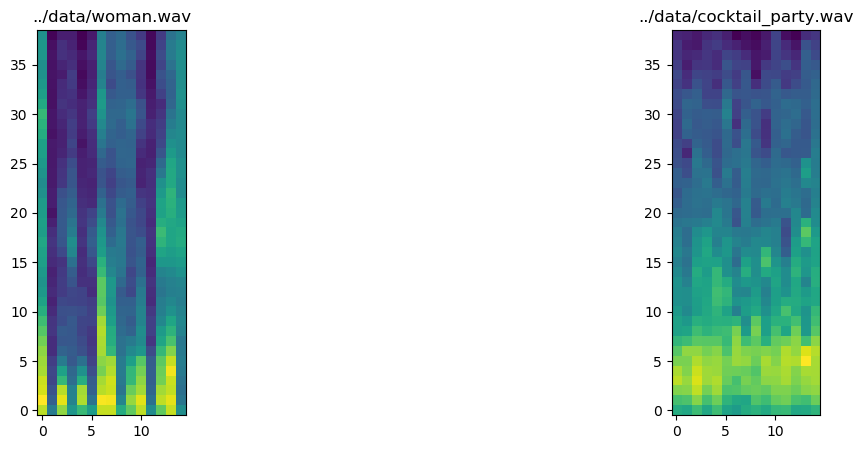

In [11]:
# plot new and previous means
_, ax = plt.subplots(ncols=length(sound_files), figsize=(15,5))
for k = 1:length(sound_files)
    ax[k].imshow(hcat([params[k]["mu_xi_"*string(ki)] for ki=1:nr_clusters[k]]...), origin="lower")
    ax[k].set_title(sound_files[k])
end

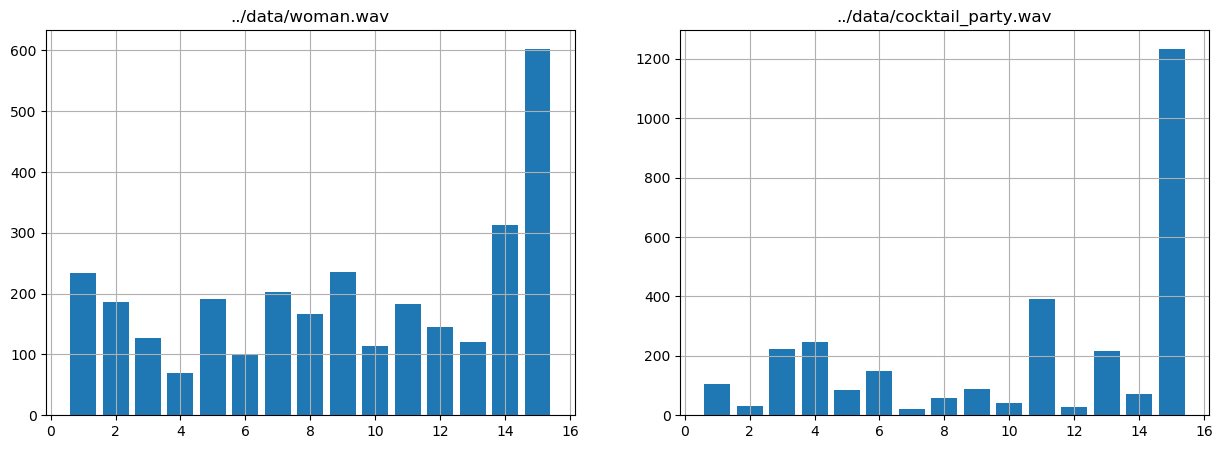

In [12]:
# plot new and previous means
_, ax = plt.subplots(ncols=length(sound_files), figsize=(15,5))
for k = 1:length(sound_files)
    ax[k].bar(1:nr_clusters[k], params[k]["alpha_pi"])
    ax[k].set_title(sound_files[k])
    ax[k].grid()
end

## Perform source separation

In [13]:
function convert_parameters(params)
    params_new = Dict()
    for k=1:length(params)
        for ki = 1:nr_clusters[k]
            params_new[pad(pad(:μ_ξ,ki),k)] = params[k]["mu_xi_"*string(ki)]
            params_new[pad(pad(:Λ_ξ,ki),k)] = params[k]["w_xi_"*string(ki)]
        end
        params_new[pad(:α_π,k)] = params[k]["alpha_pi"] #ones(length(params[k]["alpha_pi"]))
    end
    return params_new
end
;

In [14]:
function observation_model(k, nr_clusters, nr_freqs, bufsize)
    
    # create factor graph
    fg = FactorGraph()
        
    # create models and combine
    for ki = 1:k
        
        # create signal model
        model = signal_model(ki, nr_clusters[ki], nr_freqs, bufsize)
        eval(model)
        
    end
    @RV xtot = sum([vars[pad(:x, ki)] for ki=1:k])
    
    # add observation noise
    @RV y ~ GaussianMeanVariance(xtot, placeholder(:Σ_meas, dims=(bufsize,bufsize)))
    
    # create output samples
    placeholder(y, :y, dims=(bufsize,))
        
    q_ids = vcat([pad(:Π,ki) for ki=1:k],
                 [pad(:Z,ki) for ki=1:k],
                 expand([expand([[pad(pad(:Ξ,ki),kii)] for ki=1:(nr_clusters[kii])]) for kii=1:k]),
                 [pad(:Xc,ki) for ki=1:k]) # this variable is deterministically linked to all other signals. 

    q_i = vcat([vars[pad(:π,ki)] for ki=1:k],
               [vars[pad(:z,ki)] for ki=1:k],
                expand([expand([[vars[pad(pad(:ξ,ki),kii)]] for ki=1:(nr_clusters[kii])]) for kii=1:k]),
               [vars[pad(:Xc,ki)] for ki=1:k])
    
    q = ForneyLab.PosteriorFactorization(q_i..., ids=q_ids)
    
    return fg, q
    
end
;

In [15]:
signal_s = [ymix[(ki-1)*stepsize_sep+1:(ki-1)*stepsize_sep+bufsize].*window(bufsize) for ki = 1:nr_samples_sep];
t_s = [t_sep[(ki-1)*stepsize_sep+1:(ki-1)*stepsize_sep+bufsize] for ki = 1:nr_samples_sep];
;

In [16]:
# convert parameters
paramsc = convert_parameters(params)

# load graph
fg, q = observation_model(length(sound_files), nr_clusters, nr_freqs, bufsize)

# create algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))

# specify priors
#priors = load_priors(1:length(sound_files), AR_order, mode="separation")

# specify hyperparameters
hyper = Dict(:Σ_meas => Σ_meas_sep*Ic(bufsize))
hyper = merge(hyper, paramsc)

# create dictionary for to inferred values
vals = Dict()

# separated signals
μ_separated = Array{Array{Array{Float64,1},1},1}(undef, length(sound_files))
Σ_separated = Array{Array{Array{Float64,2},1},1}(undef, length(sound_files))
c_separated = Array{Array{Float64,1},1}(undef, length(sound_files))
for k = 1:length(sound_files)
    μ_separated[k] = Array{Array{Float64,1},1}(undef, length(signal_s))
    Σ_separated[k] = Array{Array{Float64,2},1}(undef, length(signal_s))
    c_separated[k] = zeros(length(signal_s))
end

# convert parameters to more suitable values
μ_ξ = Array{Array{Array{Float64,1},1},1}(undef, length(sound_files))
σ2_ξ = Array{Array{Array{Float64,1},1},1}(undef, length(sound_files))
p = Array{Array{Float64,1},1}(undef, length(sound_files))

for k = 1:length(sound_files)
    μ_ξ[k] = Array{Array{Float64,1},1}(undef, nr_clusters[k])
    σ2_ξ[k] = Array{Array{Float64,1},1}(undef, nr_clusters[k])
    for m = 1:nr_clusters[k]
        μ_ξ[k][m] = params[k]["mu_xi_"*string(m)]
        σ2_ξ[k][m] = 1 ./ diag(params[k]["w_xi_"*string(m)])
    end
    p[k] = params[k]["alpha_pi"] ./ sum(params[k]["alpha_pi"])
end

marginals = Dict()

prog = Progress(length(signal_s))
# loop through signal
for n = 1:length(signal_s)
       
    # fill data dictionary
    data = merge( hyper, vals, Dict(:y => signal_s[n].-mean(signal_s[n])))
    
    μ_observation = fft_reduce(FFTovertime(signal_s[n], bufsize, bufsize-stepsize_sep, rectangularwindow))[2:end-1]

    log_p_posterior = Array{Float64,2}(undef, nr_clusters[1], nr_clusters[2])
    for k1 = 1:nr_clusters[1]
        for k2 = 1:nr_clusters[2]
            log_p_posterior[k1,k2] = log(p[1][k1]) + log(p[2][k2]) + logpdf(MvNormal(zeros(nr_freqs), 0.5*diagm(exp.(μ_ξ[1][k1] - σ2_ξ[1][k1]/2) + exp.(μ_ξ[2][k2] - σ2_ξ[2][k2]/2))), real.(μ_observation)) + logpdf(MvNormal(zeros(nr_freqs), 0.5*diagm(exp.(μ_ξ[1][k1] - σ2_ξ[1][k1]/2) + exp.(μ_ξ[2][k2] - σ2_ξ[2][k2]/2))), imag.(μ_observation))
        end
    end
    log_p_posterior = log_p_posterior .- maximum(log_p_posterior)
    log_p_posterior = exp.(log_p_posterior) ./ sum(exp.(log_p_posterior))
    
    
    
    for ki = 1:length(sound_files)
        data[pad(:C,ki)] = 1/bufsize*hcat(cos.(2*pi*freqs*t_s[n]')', sin.(2*pi*freqs*t_s[n]')')
        data[pad(:p_z,ki)] = squeeze(sum(log_p_posterior', dims=ki))
    end
    
    # specify marginals
    marginals = load_marginals(1:length(sound_files), nr_clusters, nr_freqs, data, signal_z, n, mode="separation")
    
    messages = Array{Message}(undef, 40)
    # perform updates
    for it = 1:iterations
        
        # perform inference
        Base.invokelatest(stepXc_01!, data, marginals, messages)
        
#         for ki = 1:length(sound_files)
#             Base.invokelatest(getfield(Main, Symbol("stepZ_"*string(ki,pad=2)*"!")), data, marginals)
#         end
        
    end
    
    # get separated signals
    for ki = 1:length(sound_files)
        # complex to real
        μ_cx = ForneyLab.unsafeMean(marginals[pad(:vars_Xc,ki)])
        Γ_cx = ForneyLab.unsafeCov(marginals[pad(:vars_Xc,ki)])
        μ_rx = vcat(real.(μ_cx), imag.(μ_cx))
        V_rx = vcat(hcat(0.5*(real(Γ_cx)), zeros(size(Γ_cx))), hcat(zeros(size(Γ_cx)), 0.5*(real(Γ_cx))))

        C = 1/bufsize*hcat(cos.(2*pi*freqs*t_s[n]')', sin.(2*pi*freqs*t_s[n]')')

        μ_separated[ki][n] = C*μ_rx
        Σ_separated[ki][n] = C*V_rx*C'
        c_separated[ki][n] = argmax(marginals[pad(:vars_z,ki)].params[:p])
    end
    next!(prog)
end    

Progress: 100%|█████████████████████████████████████████| Time: 0:05:26


In [17]:
# process predictions
μ_predicted = Array{Array{Float64,1},1}(undef, length(sound_files))
σ_predicted = Array{Array{Float64,1},1}(undef, length(sound_files))
for k = 1:length(sound_files)
    if window == rectangularwindow
        μ_predicted[k] = expand(μ_separated[k])
        σ_predicted[k] = expand([sqrt.(diag(Σ_separated[k][ki])) for ki = 1:length(Σ_separated[k])])
    else
        μ_predicted[k] = zeros(size(ymix,1))
        σ_predicted[k] = zeros(size(ymix,1))
        σ_tmp = [sqrt.(diag(Σ_separated[k][ki])) for ki = 1:length(Σ_separated[k])]
        for ki = 1:size(μ_separated[1],1)
            μ_predicted[k][(ki-1)*stepsize_sep+1:(ki-1)*stepsize_sep+bufsize] = μ_predicted[k][(ki-1)*stepsize_sep+1:(ki-1)*stepsize_sep+bufsize] + μ_separated[k][ki]
            σ_predicted[k][(ki-1)*stepsize_sep+1:(ki-1)*stepsize_sep+bufsize] = σ_predicted[k][(ki-1)*stepsize_sep+1:(ki-1)*stepsize_sep+bufsize] + σ_tmp[ki]
        end
    end
end

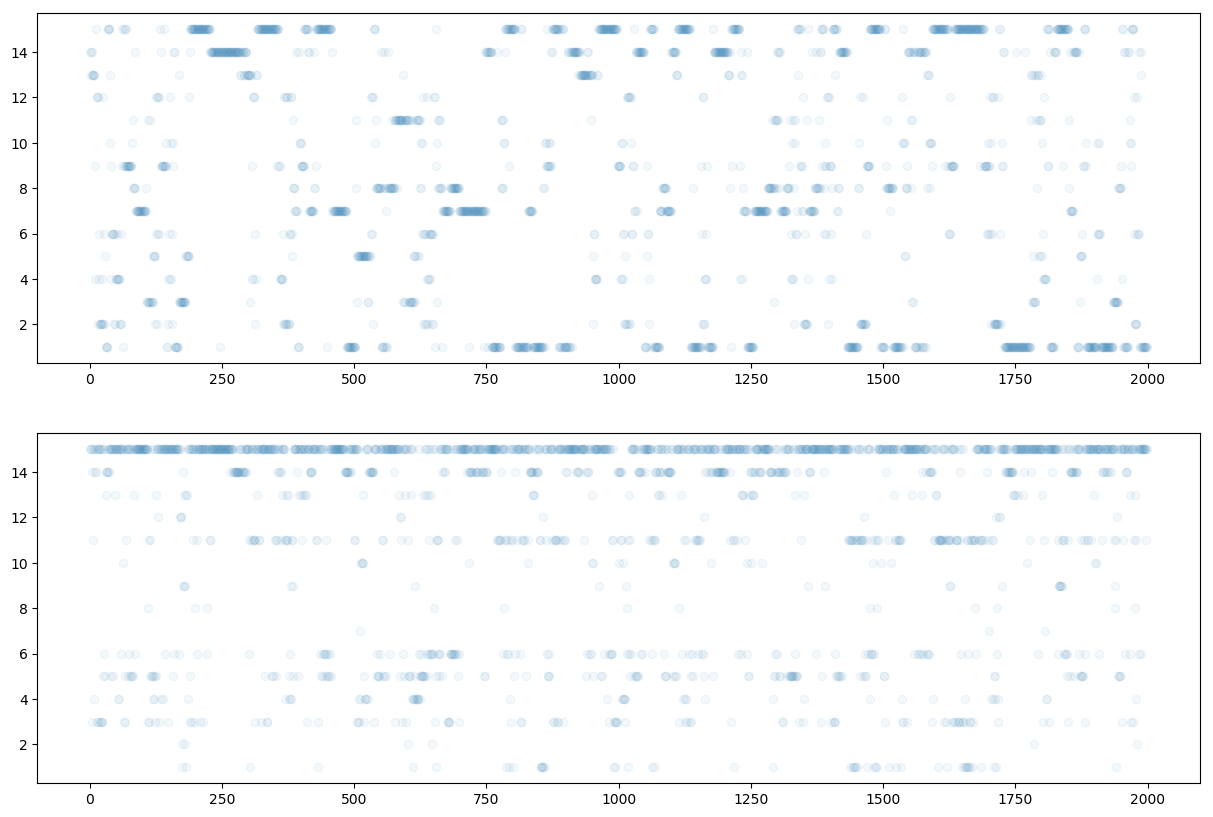

In [18]:
# cluster assignment
_, ax = plt.subplots(ncols=1, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

for k = 1:length(sound_files)
   ax[k].scatter(1:length(c_separated[k]), c_separated[k], alpha=0.05) 
end

## Analyze results

In [19]:
audioplayers(signal_sep..., ymix, fs=fs_desired)
audioplayers(μ_predicted..., fs=fs_desired)

<source src="data:audio/wav;base64,UklGRjziBABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQDiBABkDXq/GRarvzkVcL9U+kq/2tQMvyjhiL2ekRc/xc2JP6jj0T8zRQlAP64XQLHjDkDmBwpA8pesP8Y4Pj5y2pG+FsVxvul5f7984ui/fOfBv75RLr9DTOC+JlzEvjimSbsjquA+mSvbPpZzJD4jxh6+abX0vojZFr84JUa/n0eLv6R/qL83zYm/v3RAv4xKF7/wX8q+rF6PPuVdij8yZ8s/d5j0P6ErE0Cf4RdAd8IRQMQwwz+O3bw+Yu19vscHer4jP3C/nTbvvz4p4b9U1mG/PB3pvhCCC7+OVGu+sMa/Pi96Dz/gfa0+epXrPYt5IL4kLuS+reQyv/FGbL9fAKC/IdKbvwvTcr+akTS/OYPKvhejuz4KQaE/RcHiPwA+BUCiBR5A+SUmQCK3/z8ZMzA/AC+hPTl+pDp7cTK/z3j1v/HwA8BKeZy/CkNGv/5Far86aCW/poJ2PnjVTD/KuxM/TCs+PjkOAD5tb3g++u0gvrB1Xb86TZu/6SSIv6W0c7+pX3S/xelEv9Y5L72tXFo/dcm+P2EH4j9LFAhAo+0gQBf1EkCs9Jk/ooQEPkf+Ij2LCj6+hsuuvwY9D8B3R9a/eUuAv1EDg78tEoG/8fCovp20nj7kbvo+HW2vPpGTAz5cAh49GygRPvefIb6H5FW/8CN3v5yy7776AH++fe2JvnUd6D57TM8/FA8JQC//CEC5rwpAtim5P61kIz/o5OQ+koOfvZQnu7+uYfq/2fqsv9b6k7+nHLu/0XyMv6Z7Cb61jOU+YmwcP2aORT9VZxw/AjHLPu+M2j4Gpiw+FFc+v49Bpr/ox3O/ZZFXv4iKqb9lr5u/S4ykvg43mT6CdtQ+49tOP2ZBrz8HPtA/tOq0P2kulD9jMWk/xZgbPybVTD41qYC+E82/vp4vzb7ePkK/qemIvzWjRb/Slwa/hhMmvzmBG7/ObuC95v7FPXpsGL6hv5++vZ1tvogkFL7lvBW+gLi8veGD7j0cExs/bziYPyfLzD/RQOw/68QNQBEt+T93LBg/SUK+vUyYYD4bSMO+PWP4v7wHAcDURmW/UohOv7LHtr+821O/1kPiPqOGXj82jiU/r8RQP17Vkz8CxI8/Lro3PxK+Bz6ECa++zIoUv5ryJ7+2jIK/hpKhv5dMer93e+q+7/zDvuDBrr6iZsE6fcPOPof7xj6PIW8+XgFuPqgadj5TWWI9ANmEvtiBpb7/GGK+0sU4vvgZgL5sdXC++IUsvgoYW7zR/Ww9OcK3PBbPJL2Rs0Q9AkehPU48ZL2VOlu+zW8rviznW71oOwG+MJCQvU5o7D1n4GU+cKNYPv7zlT7tfbs+7uzSPqGLqz5CU2c+b0sdPiz69j3w1ZU8S/NZvvsIm76Fr5S+yAa3vqFu+r5sSdW+G3elvrZipb4V4p++RDBCvunL/r0qNOq9ZYklveHERT2MW8Q9pERDPg+duz6eaNI+MqXaPo8rEj/JySg/nrcQPxkB4D7Aepw+5GBUPvxqo7yRdYq+6jUMv03dN7/zM0K/+C5Cv0sGXL/4X1G/W38Sv1pO1r5Fzqy+It85vtCyezs+Du09wXNuPsAznD51+8I+QgMaP01eXD8OC4E/EDGUPx53mD/xO3U/iT4SPylI2D5C8s28Nokuv4aQfr+ny3e/V0KWv8HZu78anZ6/I/lSv2H9Mr9RViK/29uBvlbk2z0QMFc+1GyZPrb+/z6fZyw/YvQ6P+jeXj/hC5E/hBiwP5Ywvj9yS4k/dQSoPrD7Sj5nCqs+j+qtvrWWnb/wLXC/EK7fvnPNc781baG/Pn4Gv2ntEj0uDHa+41/tvXKOAz8RDis/WnS1PlJKuD6E/f8+1UFRPkoeTb7MrGu+nRl5vmn9AL8w7x+/GggNv0Q9/74TJuW+vPmrvvpHPL7GRJu9AKy4vdJUkb2Q5907nx3YPRi7xzy74YS9l5znPHUfbD2wzoW9maV0vQB9RT0AqBi90t70va2wtr0RfW+9CiByveA0+7w4btU8jkMsPY2wZz37UYY9AAuwPU9WXz6eXnI+pcETPjCa4T2CZEw+WXM2PkSkyT3Tww0+0c4aPko1TT0NyXO78v6eOg7fNL0veGC9ZZRtvbIGU71+Xli9H4hYveh5h7vQlIC8TTloPOW8RD1+oQo92TeoPfu4FD4uaZw9XK66PTuoPj5v7gE+Tm8KPR5Ozz3NCTk+FMbVPXV1Vj3/TDo9imhuuzQQcz0wL9o9zw1ivUOIiL0QBKk97KWIPeuuUr0BxoU8wQwUPS9A1jtgEXc9jzQoPXmHjTuAqDg95STUPbb/Yz0wQE88dvi1PUnCRz2HYgU+Ps6RPWsCnjtjv0Y+lwfNPVNsbj2IaCc+miPCPMtOtjtMZxk+qXWWPZZJ470X7Ry9Ha6BOjVEv72xxG68Fk0SPBvcj73C5oI9tFIfvdSmOr6u5tI9bKJGPg+G4738AXy+fLamPX7/ZD64TT6+rqIXvqahdD5OMgK+tedLvtVHgD56nH68vrC8viGrszxQ9AA+lztmvgBWgr6j1Py8P6aMvQz6Ib4o2T+9JAYvvsppur34gAw+f2zdvRlzmr5xsNc9zDSNPV66Z77uQ5+9S0UjPSWRjL3+9Be+7MXvvAdokjwZBye+8T4LvmS6I73QBzG9ttkhvuFOFb7V/0K9lF6wvSCJi73iDju9Sk1ZvFuOL7z+46e8sretvJSVwzuph8c8XbwdvdP+27ziBqe7VaPCu3P5q7zST2u9Lk8Bvd1oD72NxwS66GkbPCJSjDutAiE7AbIlPbNjhjtMPwK9r9FgvFdZIr2IBoO9GyuGvbP1V724r4O96d7MvbQGkb2l7DG9gysXvHEdxLzWwp07lbyFPUIpeD2ZFeA8wcgiPUvbVz2uLbw84/+UPJYmmTzw/cA53l3eOwvXCLrIoNC7QVYPvLRsIbxyQ2s8Wpw/O85pDL0dcRO9hGI/vUDyU7218la9HDM/vevJOLxwn7E7h4oMPcl7RDwAZsk7O+BAPcLoXD0kA5A80a9tu0mBEz0zUxw97bkpvG5owrqgbx095jkZPa+Qcjs1EKw7FjYePY9IIj0ucVc9Vkl2PaXsnT1x2H89jbCSPbDrcD1XhEE98ihlPULmCj2twXY82JchPdGpHj26d409UEJ2Pd01Lj18dU09L+dIPc4PLT3zRBg9xkhhPas2lz144Sc9AgsBPbZ4aT2ORj89uKB/PTrAyT1tp6c9XNZmPfPCgD00GH89KEeOPNzAJD2m1tM79yL/vLFMML2g4iO9GPLEvJ9QEr2Vteg6gp/jPCzQNzzvK8k7cRqOPH2wMTz8tbm8sAcmvaeUX719DIS9UqKCvSlMur1oVt299x7VvUPCwL0w/fK9N0a+vTJipb16OMu9FuvPvSinzr0oWdK91KwCvuS08b1RLQi+IF8IvkgOBL5muvW9EDQGvgqY/L1B6429pAzLvdNuxL25mKW9f8mavY0HnL0XFfC9jWj0vci2AL6v1NS9ODvFvWmfyb0fUsW9p3+3vePMyL1fPuG9tXnavRZylb0TGqe9LwTDvd7+k72bJFy9j86CvRTlI70HwfG8ay2Dvd6zar0icgK9kDnIvIN3xrxfGf28F/cavVV3zrgBxiS8lb4Su4ItHjxcaeI7WqnAPGYMWjwQZwA8xIXjPLDcLryTuN68B5IaPGd/kDsjB2E8GTABPCw8KD10jQw9nmDaPIQyYT0IQYI9vW5jPfYHxD3AMJI9pWaNPVizgD2VoGg90bCQPXt+Rz0eQ509OfluPSDdNz0VPkc9cUShPYxnlj1Edm89PemyPTWGsj3U8lg9ZVOKPYlurz2BF8k9sAzPPfWiwz3gaLQ9senNPYnI8j2bMLQ9AV6NPTqjtT3ap

<source src="data:audio/wav;base64,UklGRjziBABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQDiBAAW+Qm9mz4kvTs467zCvhm94lwrvcgrjrxvvXs9YvABPhsZYj7HxqI+KBrUPjoY6z6yUAA/ceeyPl+/tTwadji+o9Atvi+X8r4uH12/W9E7v5Ymn76JX2q+XDZovk1K4TxcfZE+8ihpPjZoqj2X3129GmF9viamqr6NXfq+QaBMv2pbib8A64C/rnxLv+xWNb+xKA2//iFxPgUXiT/hIcg/Psv6P6aAD0B1UQtAFuQDQKtrqz+94kw+rRfJvlQLvb4JIl6/4x7Nv9KIub83Wi2/neXGvjqx+b7wSD2+Uk6NPpSfnD4s+9M8THA+vvM1+L5X4jW/ZD1WvzIHeb8YSYq/U6VJvzepub6zbAi+RxrtPQLaOT+JbaU/W2WuP7hGpD+3B78/RhvWP6cYoT95Jrs+4ruIPfJEsT4Luya9/pWMv1Jto7+B5he/DW/kvuZPZL+FrlS/PO79vTWRkj72qYM9qCBevtPiAr4MvqQ9K9UTvuX2J7+edmG/1DApvzpaDb9MHz2/Oik8v3Hhcb7e2tE+T7dhP6xEjT8yGb4/dGcHQJoFDEBawLU/QOAYP7cgyD6SeH49Zo+Bv5ME+b+MoMq/1jt/v+g8hb9sNn2/ykSIvk6Gnz5Tt/c+qtvhPjOUfT4kUEu9ueixvdm4n757AU6/yfx4v2wqB7/hgvm9CkWovQau3j5orbI/sunrP1OO7z9x0uk/S7eOP/SMrD6AL5s9O9XsvhT30b/dbwLAzfWpv3c/Yb9LS4K/36Qvv+sDLD4ciCo/7jUuP37LGT8rgbQ+1xk8PuzmjT44bsA9UrEKv95UTb+qxcq+/zievucWUb9UDl+/lb44vpO4Rz7UzGq7Tv1GPhchOD8M33Q/vKI/P/cXFz98dxY/DRwKPxxguz50V7I999zZvFT3UjyGcDi+NL4Mv4wHE7+NoQe/K/JWv3Eyhb8f0UW/tLgEv8Cf/76gR9K+H+JQvioIkzzRYYk+MHjXPlvEAz/5KWA/YTitPxrruz/ozbY/R6HVP3Yntz99UaU+b8ZWvruyDj6M0Ku+SKDDv+CNvr/swBW/0wcmv460jb/lugW/3u/jPgntDz/URN4+gOw/P0skdz+MRmQ/1atCP6obyT63Gfq9BofWvlfHDb9hyGS/LuGVvyDlgb+AZB+/c4fjvi9Imb5D+oU7BTemPpuN4T7HINw+QHjiPj+M8z4Nzcs+4PEJPtzhxL2AEDG++ilovupM2b5nrgq/Cufzvppyxb4u3JK+kqQvvslAEb6UXL+95lZRPeN24z2MP8e8c3lUPUAJWz6H1zU+ARvTPUW+Yz5kCrI+WAGLPqM/aT41wJk+b3i0PmUclD6jZ0c+c+ioPeLiHryrUCu9wC8AvqYFc74KV4O+Mg9bvj1dfb6s7Xe+wAcjvpiKBr6O/Q6+F9p8vaHl7bu7aUu8DRqHPcHl4z1ScRA9HrXYPR2Hlj7ep5Q+0AtRPrtCoz4svOw+sK7BPuvmZT65OjQ+fQhgPbSGEr6rg6a+xqnvvqQrDr/x+w+/TbAXv/mBQL/+8ES/mZ8Tv0qW+r4Syuu+S8qHvuzihbs+bjE+ME+3PvptAT8pYxU/5f5KP6LUgj+JKYQ/c+yAP38Thj/E81g/b5XrPrF5eD7iQ7C9Zckkv5v5bL+7UGW/wfGOv075u7+nAqa/YoxuvzxgeL/zOnm/Ju/3vsfXvbwqdpo9wzyNPhVQOD8AVHk/LyKIP+0+jj+NFY8/ANicPxQGrj+LiXU/7bmOPkJvnj5cfg4/zMMBvl9+eb/svyi/3X4CvjsQHr/wOIK/rkK2vrrNJD5Awze+DQ2Evt4AhD4Tks4+A7uOPVfHsDwYkYQ+va4zPhciKL4bvZG+bUiHvuaZtr4XQ/G+Q632vjFM1b65T52+RMs4vqjtjb0bpTY8BNObPb/IAj4cnlM+YFRFPoevqD0h0BY91h+LPeZsqrxylUu+XeBQvvf52r0D6eK9zaMdvgvcDb48imi9eiQcPZUDvD0VOpc9GlW9PW83Gj6RAwc+okHWPWXI+j1VMAE+HpztPcNXBT7EQvE9hxNmPcYVET2Q94k9pR2NPYnaAD2zF5E8fShSPeL+fT399hM9ptQ3PKJrozxW/UM98qZPPRlb0jzRx5g8vz+Eu3oS1ztwsMI7dRwPvAz37bvfDZU76ontO+80i7oaqII7aJ2WO9OmWrpxFYI8ePbIPBKH1LmiaDc7oytGPFKHgjwEO8s84jCROjeTX7tCpSM9EqwMPa54ZLxBlwK7jpd+PAArrTwSsYs8F6U8PBzwYLux74Y873LZPDhWeTv1LDg7dWY5PDmaZbytkjU9wxxgPLeZG713odQ8RWjXO8yDmrtpEcI8MRDsum2E5rwdvqs8L6dpPHQrurqgBlO778sdvO5lCTyoVW08fgehu3Gy1bwy24s8gbYBvYbxmr2EKZw95suWPXS4sL2ZpOS9O3MCPUq54z0o6QK+XfzXvSAmLj7S4Iy9ho8JvvntID6PndC7cDR1vmXunD3UchU+r6wAvgaP+L3X+6o9M90xPbkEj71t9P07M1PcvWxgAr12MD4+inX/vMdBXL61Btk9FZu9PY7bBr6Sc0e8ZDQ5PV+GPr0MmJ29Hc/WO3HpfD1d0Ee91v4tvdFW1jwEtEm82aorva1aErwxoPk8h/yVvEBXcb0Y1Tu8w/F7PWu7CzwQnjW9jYMavYWFZbyljG08X5UCOwrPojppWIK7efsJu93UwzuuWU85fn04u8HtwbvU0u47Dxb5O/XmIjxYtEU8PCyTO5RCtjpAY0M7n02HO3YQNTtYUz87p7utO7htgztnz3w7dFCzO2e8oTv0XoI7Za6hO1kXzDs2pX07H2pgO/vwqDsJ5FA75myFOqiQQDuzXwE7u0C6ORe7yzp34cO6eYq1ujwHwTmxBOu66v0Uu/z1FbusBfC6P5P+unrpfbsU02+7Tv5Ku5WVB7uG8wq73R6Uu5rTg7tXzDu7aOtiuzM2+btvgoG78c05uzhbeLuUXgC7nCz7umauqbp83eE4Qv/rOm0R8jrjpLc6qriEOz2OgDsUWlM7/YOaO3udrDtMVQc8iKC0O1jSmzuZAgI8bM/lO6yy5zt0O+s70NIXPLYBEDz4A+E7VMUWPCFcETy3SQQ8RwkMPGzDFjxDbgI8NpLwO9pKDDxOGAI8VBzVO2ufyTtRbeA7y3TOOz/OvzuJ/Vk8qEZLPM9CVjw622c8Ia1jPAX4QDzbu0U8K+8zPP7BKDzuxAw83GEXPOOwBjx4j8I7AS3EO2S8kDsPFvs6docIO/9stjr/AAS72rGvugm50rqP2Hu7F2yYu8NDwbvfX+G7RxIJvFC6IbydMgi8iVkxvFdbT7yqYFS8Bd5ivB2RX7zVama8QnBuvMWeebwzRnO8MQV0vED9a7wMrni83/MHvMEaw7ujRO67PgQDvFTSCLzqaPm7KDAEvMyR7LsPldm71v7Qu6kZ9ru7gAO8yFDdu+FMBbzBihq8z1e+u7pLuruU0AW8SGfQu3A3rruKy5S7HMGQu4ZKPLuMLDK7zaM8u9B9Mzqj7Y86IggsuiJdJDvUJ4M7VTk3O9VDWTuvn4I7JwrIO0AQ1TuAP9Y7XafdO9UODTzNM+g7zZoXPCIxDLybJQy86FjSu31K3LuMJq27slqmu4afzrv6JKC79yDwutA8QLtq0cC6R4LHuiSkgblpvo+5A8fJOlc+XztF6Q07wscDOzYw7TvLQNU71ifWO/3n/Dt1N+87JB4uPGjlITyL8y88zrc1PNYrUTwouVA8MkczPFz7JjyY90g8YDxhPPjCKDx2RAg8veA0PM0PNzx/vgw8LLMXPB/XDTweYwE7iqHcOgXIlDt4PWw75ANyOuXnAzszP

In [20]:
# save mixture sound
wavwrite(ymix, folder_audio*"/GSMM_mixture"*join(["_"*split(split(sound_files[k],"/")[end], ".")[1] for k=1:length(sound_files)])*".wav", Fs=fs_desired)

# save sound files
for k = 1:length(sound_files)
    if window == hanningwindow
        filename = folder_audio*"/GSMM_han_true_"*split(split(sound_files[k],"/")[end], ".")[1]*".wav"
        wavwrite(signal_sep[k], filename, Fs=fs_desired)
        filename = folder_audio*"/GSMM_han_predicted_"*split(split(sound_files[k],"/")[end], ".")[1]*"_"*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".wav"
        wavwrite(μ_predicted[k], filename, Fs=fs_desired)
    else
        filename = folder_audio*"/GSMM_true_"*split(split(sound_files[k],"/")[end], ".")[1]*".wav"
        wavwrite(signal_sep[k], filename, Fs=fs_desired)
        filename = folder_audio*"/GSMM_predicted_"*split(split(sound_files[k],"/")[end], ".")[1]*"_"*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".wav"
        wavwrite(μ_predicted[k], filename, Fs=fs_desired)
    end
end

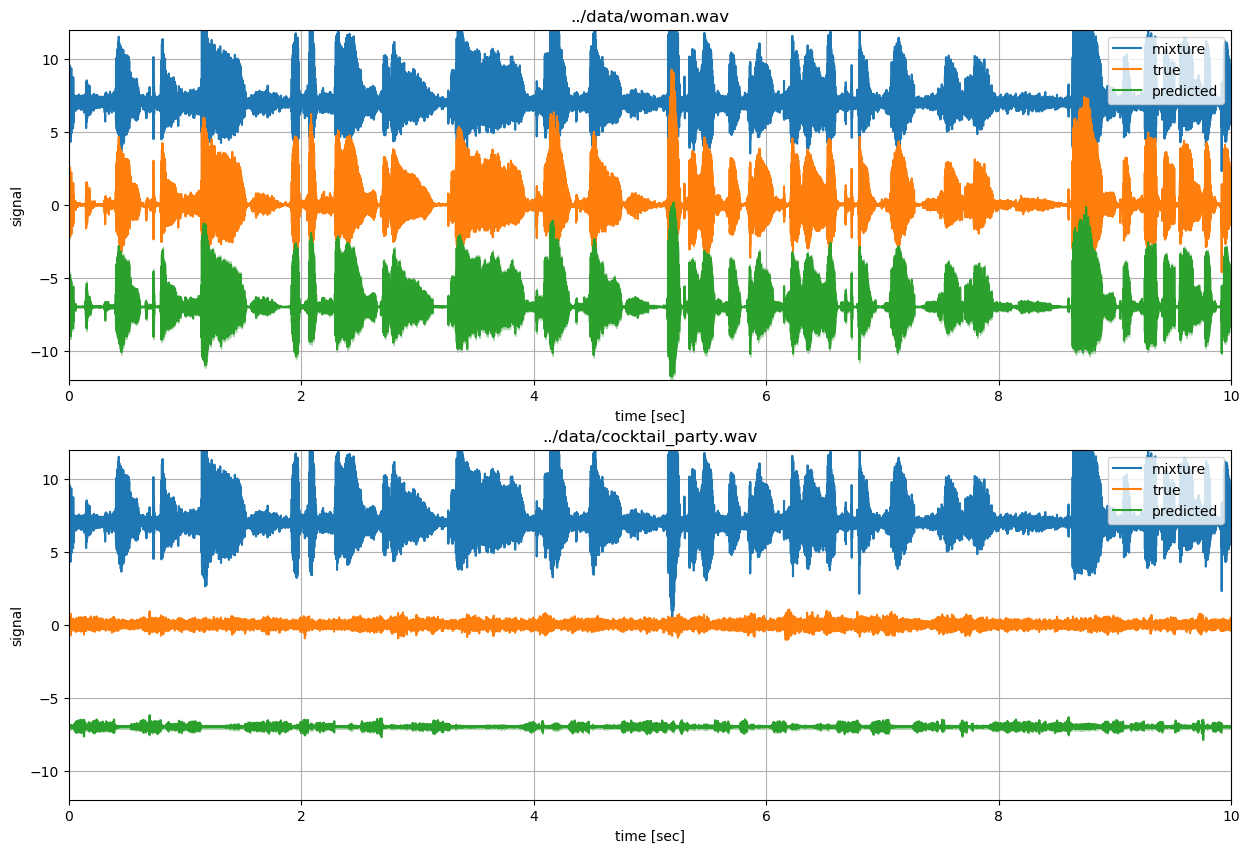

In [21]:
# create axes for subplots
_, ax = plt.subplots(ncols=1, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k].plot(t_sep, ymix.+7, label="mixture")
    ax[k].plot(t_sep, signal_sep[k], label="true")
    ax[k].plot(t_sep, μ_predicted[k].-7, label="predicted")
    ax[k].fill_between(t_sep, μ_predicted[k].-7 .- σ_predicted[k], μ_predicted[k].-7 .+ σ_predicted[k], alpha=0.3, color="green")
    ax[k].set_xlim([0, duration_sep]), ax[k].set_ylim(-12, 12), ax[k].set_xlabel("time [sec]"), ax[k].set_ylabel("signal"), ax[k].grid(), ax[k].set_title(sound_files[k]), ax[k].legend()
    
end

# save figure
if window == hanningwindow
    filename_figures1 = folder_figures*"/GSMM_han_time1_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".png"
else
    filename_figures1 = folder_figures*"/GSMM_time1_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".png"
end
plt.savefig(filename_figures1)

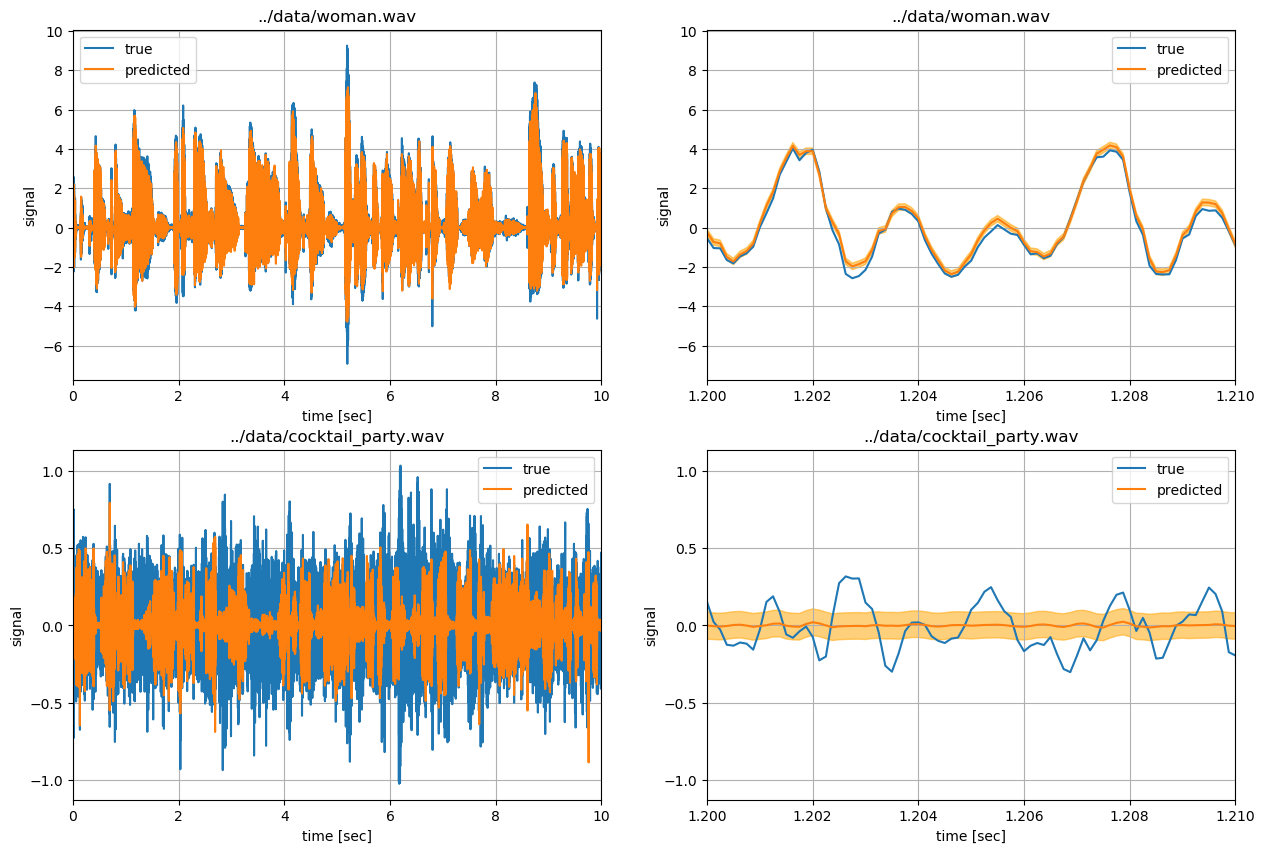

In [22]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k,1].plot(t_sep, signal_sep[k], label="true")
    ax[k,1].plot(t_sep, μ_predicted[k], label="predicted")
    ax[k,2].fill_between(t_sep, μ_predicted[k] .- σ_predicted[k], μ_predicted[k] .+ σ_predicted[k], alpha=0.3, color="orange")
    ax[k,1].set_xlim([0, duration_sep]), ax[k,1].set_xlabel("time [sec]"), ax[k,1].set_ylabel("signal"), ax[k,1].grid(), ax[k,1].set_title(sound_files[k]), ax[k,1].legend()
    
    # plot zoomed-in version of signal
    ax[k,2].plot(t_sep, signal_sep[k], label="true")
    ax[k,2].plot(t_sep, μ_predicted[k], label="predicted")
    ax[k,2].fill_between(t_sep, μ_predicted[k] .- σ_predicted[k], μ_predicted[k] .+ σ_predicted[k], alpha=0.3, color="orange")
    ax[k,2].set_xlim([1.2, 1.21]), ax[k,2].set_xlabel("time [sec]"), ax[k,2].set_ylabel("signal"), ax[k,2].grid(), ax[k,2].set_title(sound_files[k]), ax[k,2].legend()

end

# save figure
if window == hanningwindow
    filename_figures2 = folder_figures*"/GSMM_han_time2_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".png"
else
    filename_figures2 = folder_figures*"/GSMM_time2_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".png"
end
plt.savefig(filename_figures2)

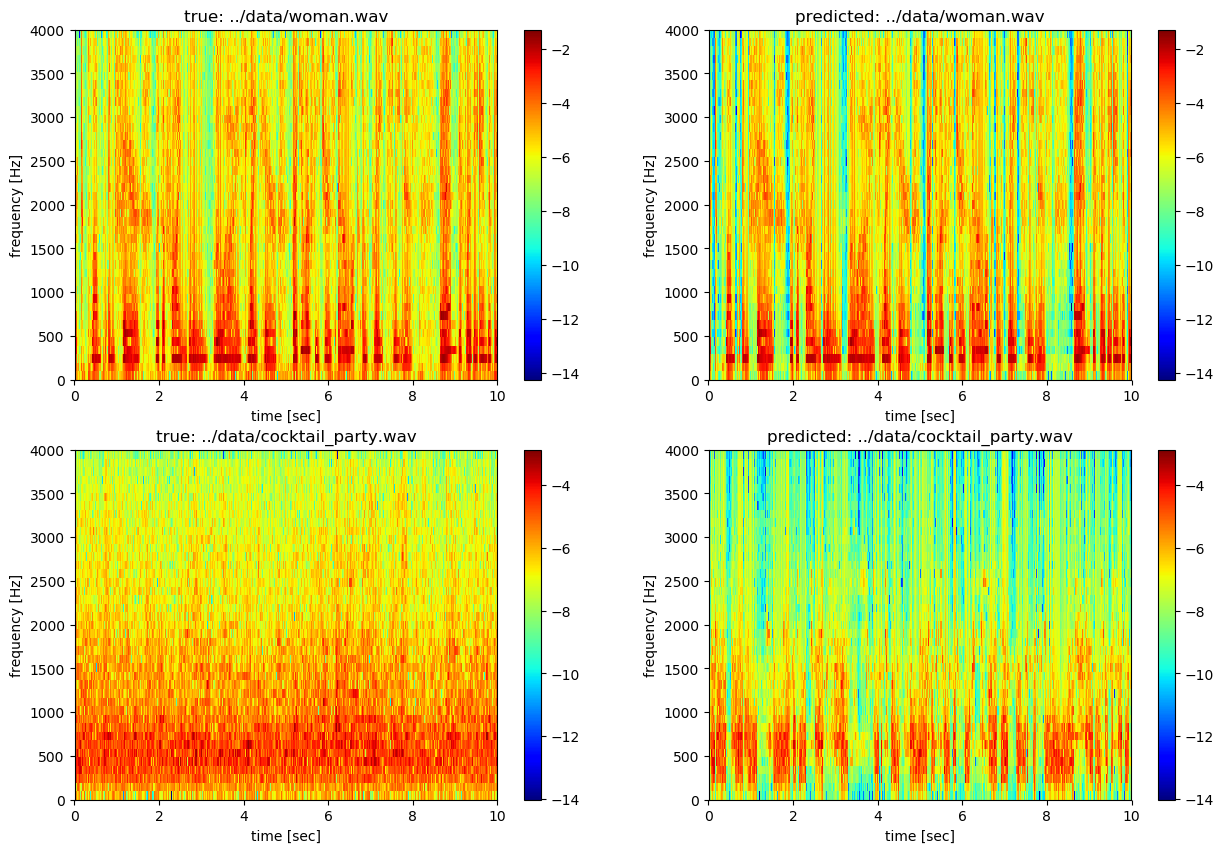

In [23]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot true spectrogram
    plot_spectrogram(spectrogram(expand(signal_sep[k]), bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=ax[k,1], colorbar=true)
    ax[k,1].set_title("true: "*sound_files[k])
    vrange = ax[k,1].get_images()[1].get_clim()
    
    # plot predicted spectrogram
    plot_spectrogram(spectrogram(μ_predicted[k], bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=ax[k,2], colorbar=true)
    ax[k,2].set_title("predicted: "*sound_files[k])
    ax[k,2].get_images()[1].set_clim(vrange)

end

# save figure
if window == hanningwindow
    filename_figures3 = folder_figures*"/GSMM_han_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".png"
else
    filename_figures3 = folder_figures*"/GSMM_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".png"
end
plt.savefig(filename_figures3)

In [24]:
using Distributions;
for k = 1:length(sound_files)
    
    MSE = mean(abs2.(signal_sep[k] - μ_predicted[k]))
    MAE = mean(abs.(signal_sep[k] - μ_predicted[k]))
    BME = mean([logpdf(Normal(μ_predicted[k][ki], σ_predicted[k][ki]), signal_sep[k][ki]) for ki = 1:length(signal_sep[k])])

    println("signal "*string(k)*": "*sound_files[k])
    println("--MSE: ",MSE)
    println("--MAE: ",MAE)
    println("--BME: ",BME)
end

signal 1: ../data/woman.wav
--MSE: 0.03913220764853336
--MAE: 0.13102009194911157
--BME: -0.30040656088240325


signal 2: ../data/cocktail_party.wav
--MSE: 0.02127426536193604
--MAE: 0.10329480447671986
--BME: 0.048234487210968006


<source src="data:audio/wav;base64,UklGRjziBABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQDiBABQsAm+E300vvnp/b0Kwu29/PHFvRF017xYSO095h1fPjZFuz4W4AE/IBcgPxNyKD+fRy0/tPrmPi+KBj2ZCFG+XnE+voMiCb/oa3m/CERQv/+dq75Aj3K+E4FwvopvAD3HdZk+NTh1Psmwrj1zfGq92vWCvj/Sq755Cvy+CndOv2atir85u4G/HJFMvxaONr+XNw+/CUVuPsF/iT8N6Mg/fs/6P7HuD0CQFAxAVAIFQEeYrD9zXVE+4yHGvvLkuL630V6/myPPv1sMvL+nWzC/aoPJvpUT/L4ROj6+DNGTPnSDqD70bks990govrGr777puzK/h7RVv4PFe78KZo2/55xRv7GfzL748Cu+N7GvPS8vNj9WFqc/TiGyPwtmqz8m98g/XM7dP4zOpj+0BsQ+o7h7PZtnqj6OK5i9T3mVvzxsrL8MkCS/rUjyvoWpZL+LYFC/VT6xvV3Mrj6vTOw9atU5vjCC4b004bg9z60avprBLb/FFWq/ucowv52xEr8i5EG/dkRAvz66dL41XdU+CqBmPzRakD/hMMI/ThEKQI3KDUABL7Y/CVgWP7cjxD4nfWA9pNSDvxSo/L/asMy/V65+vyAmhL/vKny/lTqFvvXnpT6z7v0+T2DjPrhleD6L+zK9UziivZRWnr4K606/TtR6v+mWCr9E8RG+u53avboX2D7W5bQ/1OjwP3EC9T+GQe8/sUOTP9HSuz796bU9slH0vgcy2L/BkgbAJ8Kxv1hxbr+jYoe/10k0v265PT6VKzg/oAc/P135Kj/G2cw+ALVdPrKsmj6tPs49LYAOvwM0Vr/9huO+d923vt08Xb/uumm/FfFSvnGoPz5nWSQ7ZbRaPjPcQT/CJoE/sE5MPyFHIj8jTyA/WZYPP4mxwT6ZZ7g9HJsbvbDvNLxc1Fi+ldkWv70YGr+v8gy/SfJbvwMuhb948D2/OIPzvhwj776dGcq+izNJvqOamjy1mYE+2fPEPqrk9T5yNFs/slKsPyYdvz8eDr4/tU7eP4I7vj9Cga8+IFpPvi05GD66LrS+BoLKv55zxr+toyC/T4ssvzz5kb9z3Qi/jlDxPpg6HD9cYvM+n2pIPwo5gD9naG4/a/ZIPxZ5xD5QahG+DLXhvkW0Fb/Dbm+/uQ6avyIHhL+hjR6/nX/fvgzLkL5WhAQ9+x22PlvY6z6BjeE+IcjmPtff9j4FM8k+dnbzPfHn2b3Pbje+XMVkvuQc3L7yTQ2/s3T0vrKgwr4Loo2+7JIjvjBBDL58E7e9SBtBPeiR2z21NeC85SI1PbYBVj7HYiw+dkHJPdWyYj6XW7E+Q56HPkDlYz5345k+O4e7PkYanD6XKFI+ZoqqPQ92gryy7UK9oqoIvi+efb7TuYu+Tt9pviH1gr4oJ3e+ZZsevheQ+r0NLgu+fEZqvWi1IDsMrSy87X16PeXq0z2c7Vw8uR63PSOYkT6sqo8+K7NPPgyWpT7W+vE+wAjMPumiej5/p0A+EAuFPTN0Fr6Uqay+fVf2vrCqEL/0XRK/OnsXv/fxQL8Ul0W/1b0Sv6Mb+77rKey+OD2Gvm2ms7mqBTA+4R+zPml3+T4FAg8/DPxFP0m3gj8H1YY/7qeFP+fXjD+ggGY/GKz7Pke/hT61A8C9DeYqvxmEdL/bdm6/0/eSv7GZv7/mKqi/2eNuv/9fd7/jL3i/xi/2vsYbfrxMqLA9ubOTPl7oOD9rgnY/No2GPzpmjj8GdJI/4dOhP9D0sj+53Xw/iMuSPiTynz5Bwgw/sdYbvsAsgr/bQTW/X7ImvjnfI7/VEIS/k9u1voRvMD7EqSq+OVlwvtvFjz72UNU+OCSmPaBm7DwBWog+pTo7Pk+cLr7cdJe+XhyPvveRwL7q4/m+XNX/vvk5375pRaS+c1w/vo8whL03fa88AG23PYgXDj6l9lg+kztMPj5FtD2ajBQ9VDN4PYIZEr2qBmK++J1jvsnu9L0fOfq9m84nvh+PGb43UIW9xzoPPRPrzz3nIao9fz7KPXdvIT4XOgM+YTPPPQdPAz4OXgo+AXgDPuLQEz4A6gQ+MFNwPUnc/TwNzYg9ErOHPRS8qzxXXeY64yc0PWYlWD2wRro87E8DPMv1xDz1C349vmqVPQliGj1BHRs8EdrdusOxBzwm1py8aHITvY7st7wr11e8JVMGvIe8NzqNFJA8vt6tOx3lRLuynPQ8rcATPTTNuzoIRkM7xRmxO2B5nTwAFjo9wl+MPNaPgjzXvoo9LKZMPQ2uqbwEGYC8EdIyO699WjyukBg83ZMZuuLBgbzdqmI8z90KPQ82nzyAibQ81OXrPBb4qzsTz5s9d+f2PMj0Hr38+fM8VWREOTnGvrxTuCs7td35vKBiSr3U6rg84Kk8PNh0gbznQrC6e/xbO5ofizy3Eco8+T4SPNls0bx4MoI8tywBvZWDpb0JB6g948CsPVG4yb0Cqgu+7BrAPJG/4j1sxhW+zjntvfq1OD555Ya9UCAFvhLnNj6plfk7PftuvthLuD0Gnhg++YoRvj/3Dr7RjoU9fUeWPG2hu73jK6I6FBvdvQPhpbxlz1s+gEh0uzRjS741yvU9apK8PT1THr4bUz69pHAEO6bIyL07o/u96WS2vMolTz0Ii1G9xQMDvQx5RD2F0EI8cKWMvGGhhDzbqFE93dwKvIpSa70vNVe7xiykPVZFPjxPRIm9pKWavb+OY71JgF68OKvOvDNTnrw3YLO86iIXvJELZjwD5j48MciXO6aQsrv23oY8gvBLPOQQJDyO4rw83kt/PIheY7uILM+71xcrvBacp7z64ba8x2k6vHbvE7y4Ps06aeifPCVn4jxjpPU89zcnPRfIRz2D+h89cTcBPchj3zwdoQM8y2jxu0lgU7slPgO8XcuVvBIpd7zOEs28jj25vJyoX7x0LKe8Oq6vvJFVerw805e7bCQIOjkxUru3gl47O+wjPMM7gDwbbQg8CnqKvOujDL3ZDCu9/vo1vf62Qr1207+8HlD0u5SD/rqztFg8wrmBPExXojxCkcM8X9fdPEmQxTxz/7Y8vdT+PI3o2jzgwKQ8N1fHPKDqsDzoX9c8sY90utdKsLwJ/qy8fyjZvGvTo7yC6ha8D0H9O5LFSDyY60M82osJPdJtIz1hISg9H3wcPX+aCD2hhsM87sGdPOHmiDxkafM6SrWnvBLmAb0MWuq8iaS2vPA/nrxpcS+8fUZbu+f1pzx2+zw908huPaxWRD1uYCs9KQMFPTaQAD0BwuU81twGPSfqzjzllx0893x4O6SD/Lt7fMC82I/TvNgY47zsEwW956RevCxulTtE5AE8/qZJPHF9zTstsxQ6Ya6Yu2fWBLwa7Zi64nuIvK6B9rwcbgi99EECvTlB1bzMCA2911o8vduNXb25jE+9wCFKvVvtMr3SsRu925MHvK/moDxhhn4841cGO4GzNbyvYQq8sH6CuoviYDw2a8k8CDXkPEHRjTwOg1i6M9NcvCL4EL0bfUe9nloAvZL/+bxVAju9GswZvbyY57wuL7286NmtvJRwhrw5hJa8LpdwvNn9ATygOSk84ioMO+6zcjwj41w8wiUfu2FiFbwSW/G7dDQrO3DKPTvi8dS6LgtWuz/SlDv+yFs6ZoAvPKCGxrs3Csm7i2UOPGohNzxXthk8FtSbu5C0vLzZd5W89zqaO7kZNDsAQte6oLg2vLDFULyDTne8rl7Uu7J0DbvViIG8y8GovIKWRjv8ZJ87uuqPO7ziETsHl5C6Uw2WPPKF/zzdxFM9NByDPdBQiz1ma2M9D1MZPZEQ8Tyq5fM8yyazPLuUDLz6KN+8Xw9jvLJmWrseHo+7BHYkOYPrJ7uVZ8K7ufqxO95IyjwLcKA87rnGOjr+kjqTw

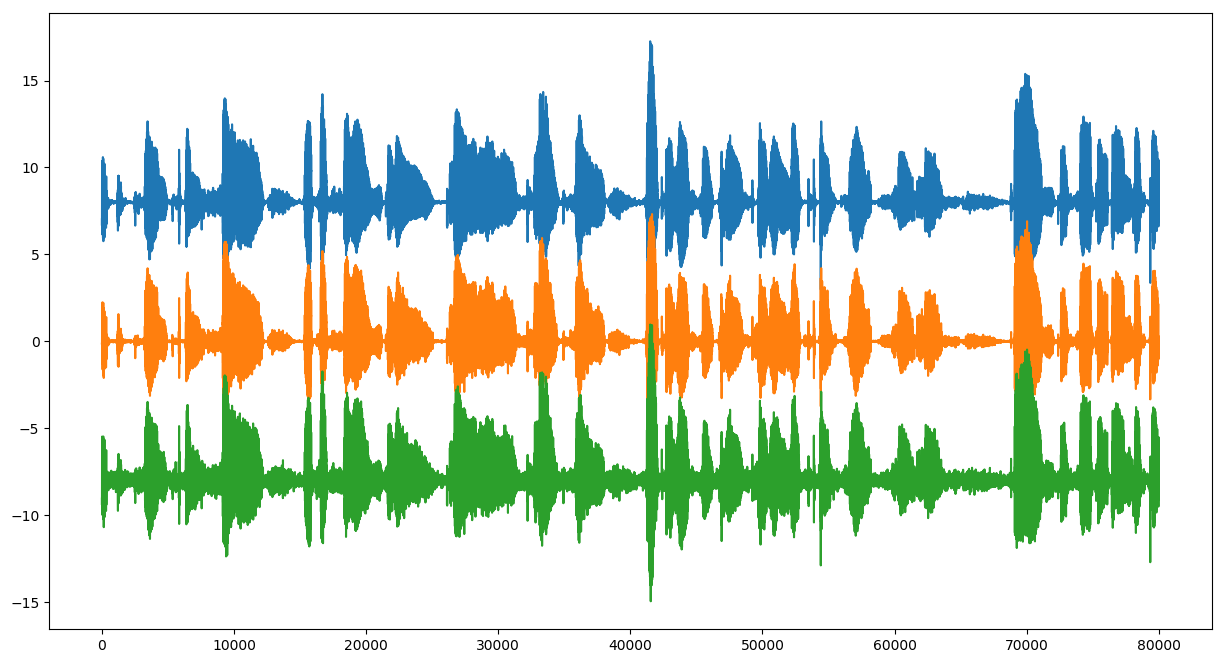

In [25]:
# generate weighted signal
w_mixture = 0.1
w_speech = 0.9
w_audience = 0.0

y_new = w_mixture * ymix + w_speech * μ_predicted[1] + w_audience * μ_predicted[2]
y_new2 = 0.0 * ymix + 1.0 * μ_predicted[1] + 0.1 * μ_predicted[2]
y_diff = y_new - y_new2

plt.figure(figsize=(15,8))
plt.plot(signal_sep[1] .+ 8)
plt.plot(y_new )
plt.plot(ymix .- 8)

filename = folder_audio*"/GSMM_han_weighted_"*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".wav"
wavwrite(y_new, filename, Fs=fs_desired)

audioplayers(y_new, fs=fs_desired)

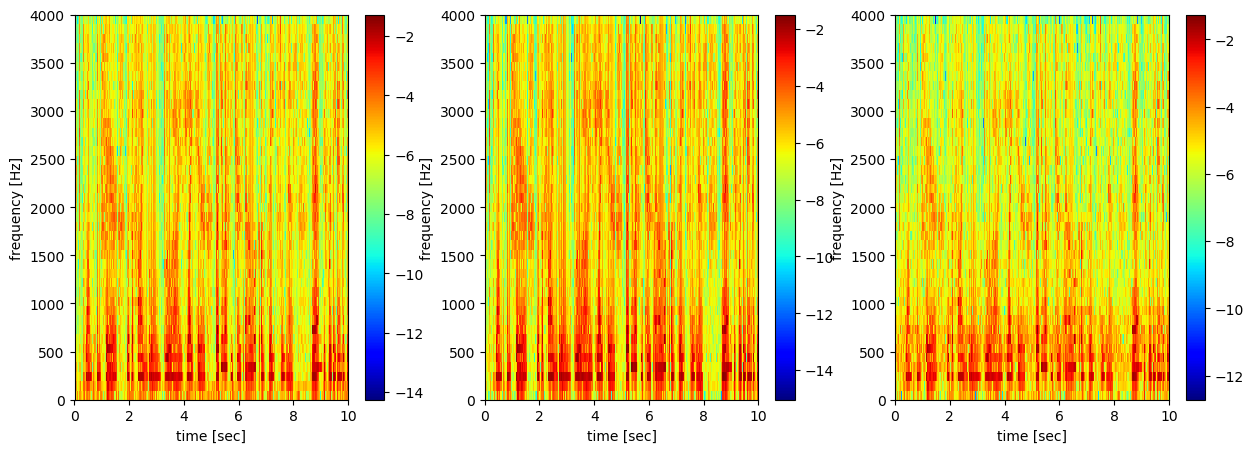

PyObject <matplotlib.image.AxesImage object at 0x0000000051D51128>

In [26]:
_, ax = plt.subplots(ncols=3 ,figsize=(15,5))
plot_spectrogram(spectrogram(signal_sep[1], bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_new, bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)
plot_spectrogram(spectrogram(ymix, bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=ax[3], colorbar=true)


In [27]:
    
if false
    
    # plt.rcParams["font.family"] = "serif"
    # plt.rcParams["font.serif"] = ["Times New Roman NN"].
    # plt.matplotlib.font_manager._rebuild()
    # https://discourse.matplotlib.org/t/times-new-roman-font-is-always-bold/20608/2
    plt.rc("font", family="serif", serif="Times New Roman NN", weight="normal", size=10)


    fig = plt.figure(figsize=(15,8))
    gs = plt.GridSpec(3,5)
    sp = gs.new_subplotspec((0,0), 1, 1)
    axl1 = plt.subplot(sp)
    sp = gs.new_subplotspec((0,1), 1, 3)
    axm1 = plt.subplot(sp)
    sp = gs.new_subplotspec((1,0), 1, 1)
    axl2 = plt.subplot(sp)
    sp = gs.new_subplotspec((1,1), 1, 3)
    axm2 = plt.subplot(sp)
    sp = gs.new_subplotspec((1,4), 1, 1)
    axr2 = plt.subplot(sp)
    sp = gs.new_subplotspec((2,0), 1, 1)
    axl3 = plt.subplot(sp)
    sp = gs.new_subplotspec((2,1), 1, 3)
    axm3 = plt.subplot(sp)
    sp = gs.new_subplotspec((2,4), 1, 1)
    axr3 = plt.subplot(sp)

    plot_spectrogram(spectrogram(ymix, bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=axl1, colorbar=true)
    plot_spectrogram(spectrogram(signal_sep[1], bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=axl2, colorbar=true)
    plot_spectrogram(spectrogram(signal_sep[2], bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=axl3, colorbar=true)
    plot_spectrogram(spectrogram(μ_predicted[1], bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=axr2, colorbar=true)
    plot_spectrogram(spectrogram(μ_predicted[2], bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=axr3, colorbar=true)

    axm1.plot(t_sep, ymix)
    axm2.plot(t_sep, signal_sep[1].+5, label="true speech")
    axm2.plot(t_sep, μ_predicted[1].-5, label="extracted speech")
    axm3.plot(t_sep, signal_sep[2].+5, label="true noise")
    axm3.plot(t_sep, μ_predicted[2].-5, label="extracted noise")

    axl1.set_title("mixture signal")
    axl2.set_title("true speech")
    axl3.set_title("true noise")
    axm1.set_title("mixture signal")
    axm2.set_title("speech signal")
    axm3.set_title("noise signal")
    axr2.set_title("extracted speech")
    axr3.set_title("extracted noise")

    axm1.grid()
    axm2.grid()
    axm3.grid()
    axm1.set_xlim([minimum(t_sep), maximum(t_sep)])
    axm2.set_xlim([minimum(t_sep), maximum(t_sep)])
    axm3.set_xlim([minimum(t_sep), maximum(t_sep)])
    axm1.set_ylim([-10, 10])
    axm2.set_ylim([-10, 15])
    axm3.set_ylim([-12, 12])
    axm1.set_xlabel("time [sec]")
    axm2.set_xlabel("time [sec]")
    axm3.set_xlabel("time [sec]")

    axm2.legend(loc="upper right")
    axm3.legend(loc="upper right")

    plt.tight_layout()

    plt.savefig("paper/cocktailparty0dB.eps", format="eps")
    plt.savefig("paper/cocktailparty0dB.png")

end

In [28]:
10*log10(var(signal_sep[1]))

-9.643274665532871e-16

In [29]:
10*log10(var(signal_sep[2]))

-15.0

In [30]:
if true
    wavwrite(signal_sep[1], "paper/original_womanm10dB.wav", Fs=fs_desired)
    wavwrite(μ_predicted[1], "paper/predicted_womanm10dB.wav", Fs=fs_desired)
    wavwrite(ymix, "paper/noisy_womanm10dB.wav", Fs=fs_desired)
end